### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data).transpose([0,3,1,2]) / 255.

IMG_SHAPE = data.shape[1:]

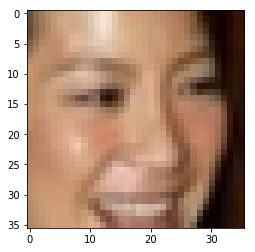

In [2]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]),
           cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [3]:
# this code is only needed if you're running this code on GPU machines
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl --user --no-deps --ignore-installed
import sys, os; sys.path.insert(0, os.getenv("HOME")+"/.local/lib/python3.6/site-packages/")

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 0.3.0.post4
Using GPU


In [5]:
def sample_noise_batch(batch_size):
    noise = Variable(torch.randn(batch_size, CODE_SIZE))
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [6]:
CODE_SIZE = 256

from itertools import count
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential()

generator.add_module(next(ix), nn.Linear(CODE_SIZE, 10*8*8))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), Reshape([-1, 10, 8, 8]))

generator.add_module(next(ix), nn.ConvTranspose2d(10, 64, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(64, 64, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.Upsample(scale_factor=2))

generator.add_module(next(ix), nn.ConvTranspose2d(64, 32, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(32, 32, kernel_size=(5,5)))
generator.add_module(next(ix), nn.ELU())

generator.add_module(next(ix), nn.Conv2d(32, 3, kernel_size=(5,5)))

if use_cuda: generator.cuda()

In [7]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generated_data.shape)

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [ ]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = Variable(torch.FloatTensor(data[idxs]))
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
discriminator = nn.Sequential()

discriminator.add_module(next(ix), nn.Conv2d(3,32,kernel_size=3))
discriminator.add_module(next(ix), nn.ReLU())
discriminator.add_module(next(ix), nn.Conv2d(32,32,kernel_size=3))
discriminator.add_module(next(ix), nn.ReLU())
discriminator.add_module(next(ix), nn.MaxPool2d(kernel_size=2))

discriminator.add_module(next(ix), nn.Conv2d(32,64,kernel_size=3))
discriminator.add_module(next(ix), nn.ReLU())
discriminator.add_module(next(ix), nn.Conv2d(64,64,kernel_size=3))
discriminator.add_module(next(ix), nn.ReLU())
discriminator.add_module(next(ix), nn.MaxPool2d(kernel_size=2))

discriminator.add_module(next(ix), Flatten())
discriminator.add_module(next(ix), nn.Linear(2304, 256))
discriminator.add_module(next(ix), nn.Tanh())
discriminator.add_module(next(ix), nn.Linear(256, 1))

if use_cuda: discriminator.cuda()

In [9]:
discriminator(sample_data_batch(5))

Variable containing:
1.00000e-02 *
 -2.3930
 -2.7555
 -2.3628
 -2.6025
 -2.3653
[torch.cuda.FloatTensor of size 5x1 (GPU 0)]

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [10]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = <generate data given noise>
    
    disc_on_generated_data = <discriminator's opinion on generated data>
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = - <generator loss>
    
    return loss

In [11]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

Variable containing:
 0.7082
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [12]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = <discriminator's opinion on real data>
    disc_on_fake_data = <discriminator's opinion on generated data>
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- logp_gen_is_fake)
    
    loss = <discriminator loss>
    return loss

In [6]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"


 1
[torch.FloatTensor of size 1]



### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [14]:
def sample_images(nrow,ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0,2,3,1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i],cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i],cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [ ]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

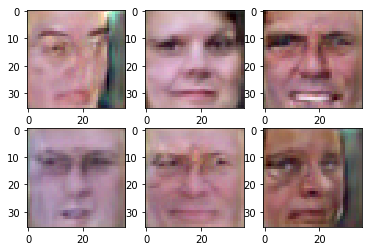

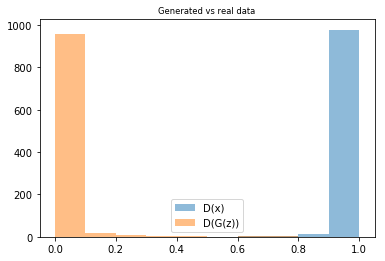

In [15]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

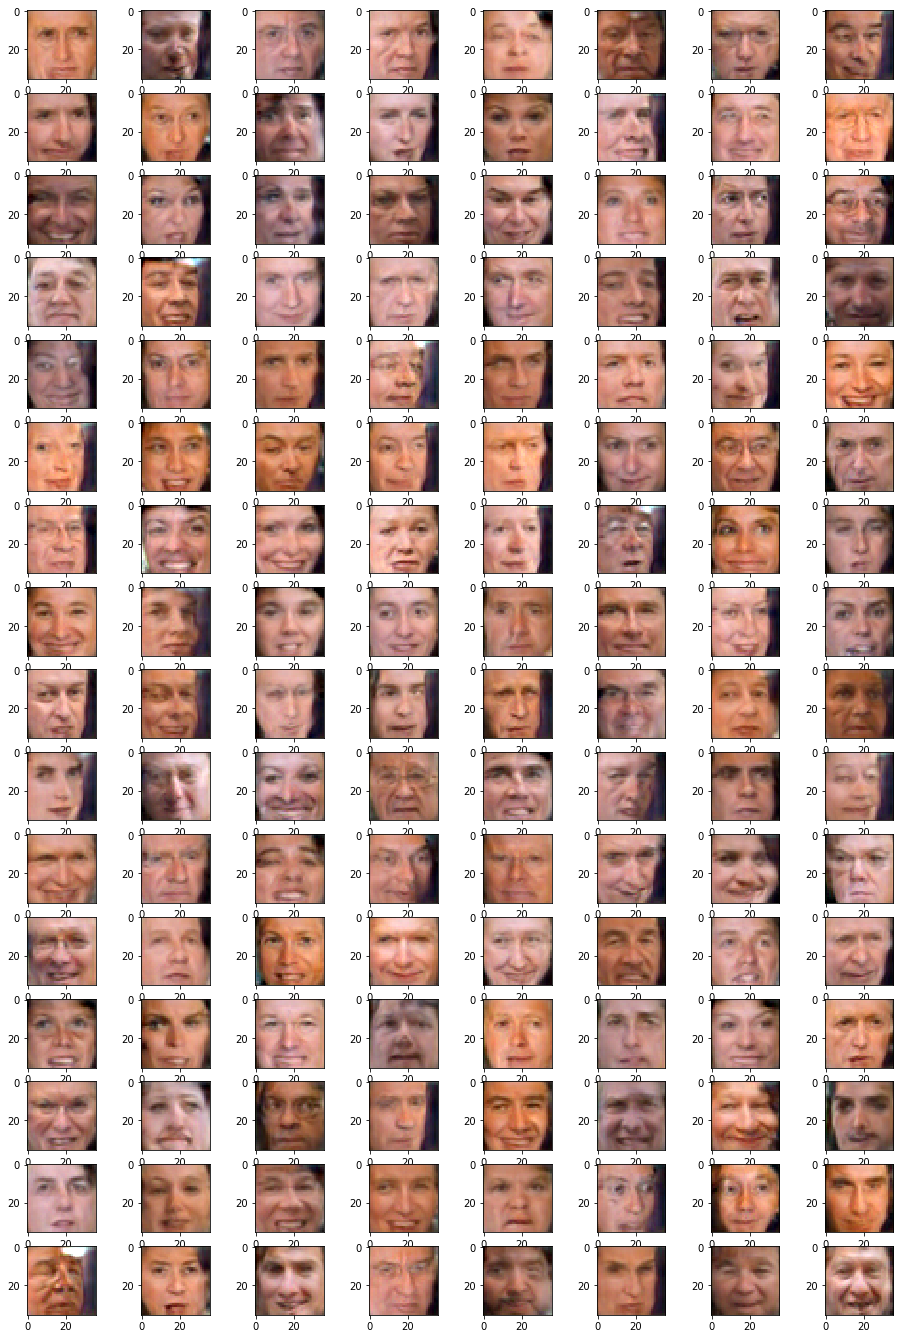

In [16]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)